In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
import scipy as sp

In [3]:
pwd

'/Users/amnon/git/paper-daycare'

In [4]:
ca.set_log_level(11)

In [5]:
db=ca.database._get_database_class('dbbact')

creating logger


# Load the data

In [6]:
gan=ca.read_amplicon('data/gan-normalized.biom','data/gan-normalized_sample.txt',feature_metadata_file='data/gan-normalized_feature.txt',min_reads=10,normalize=100)

2021-10-04 10:35:52 INFO loaded 268 samples, 928 features
2021-10-04 10:35:52 WARNING Do you forget to normalize your data? It is required before running this function
2021-10-04 10:35:52 INFO After filtering, 268 remain.


In [7]:
gan=gan.sort_samples('pn_ID')
gan=gan.sort_samples('Time')

# Age matching home care to day care samples
## One sample per child
### Start from timepoint5, look for a match < threshold (1 month) and throw away all other samples of that child
redo until all samples finished

In [10]:
home = gan.filter_samples('kindergarten','Home')
daycare = gan.filter_samples('kindergarten','Home',negate=True)

dc=daycare.sort_samples('Time')
ndc=gan.copy()
ndc.sample_metadata['pair_id']=''
keep=[]
# maximal age difference between matched samples (months)
max_age_diff=1

found_any = True
while found_any:
    found_any = False
    for cid,cexp in home.iterate():
        cage = cexp.sample_metadata['age_months'].values[0]
        tpos = np.where(np.abs(dc.sample_metadata['age_months']-cage)<max_age_diff)[0]
        if len(tpos)==0:
            continue
        found_any = True
        ckeep = dc.sample_metadata.iloc[tpos[0]]
        ckid = ckeep['_sample_id']
        keep.append(ckid)
        ndc.sample_metadata.loc[cid,'pair_id'] = cid
        ndc.sample_metadata.loc[ckid, 'pair_id'] = cid
        dc=dc.filter_samples('pn_ID',ckeep['pn_ID'],negate=True)
    

#### sanity check - compare mean and median ages of the 2 groups

In [11]:
tt=ndc.filter_samples('pair_id','',negate=True)
ttt=tt.filter_samples('kindergarten','Home')
print('we have %d individuals in home' % len(ttt.sample_metadata))
print('home care mean %f median %f' % (np.mean(ttt.sample_metadata['age_months']), np.median(ttt.sample_metadata['age_months'])))
ttt=tt.filter_samples('kindergarten','Home',negate=True)
print('we have %d individuals in daycare, matching %d homecare' % (len(ttt.sample_metadata), len(ttt.sample_metadata['pair_id'].unique())))
ttt=ttt.aggregate_by_metadata('pair_id')
print('day care mean %f median %f' % (np.mean(ttt.sample_metadata['age_months']), np.median(ttt.sample_metadata['age_months'])))

we have 24 individuals in home
home care mean 14.386301 median 12.361644
we have 60 individuals in daycare, matching 24 homecare
day care mean 14.269863 median 12.016438


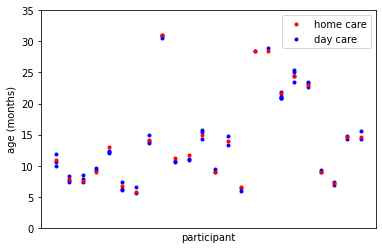

In [12]:
f=plt.figure()
tt=ndc.filter_samples('pair_id','',negate=True)
ttt=tt.filter_samples('kindergarten','Home')
ids = ttt.sample_metadata.pair_id.unique()
ttt=tt.filter_samples('kindergarten','Home',negate=True)
# for the legend
plt.plot([1],[-1],'.r')
plt.plot([1],[-1],'.b')
for cpos,cid in enumerate(ids):
    rr=ttt.filter_samples('pair_id',cid)
    plt.plot([cpos]*len(rr.sample_metadata),rr.sample_metadata['age_months'],'.b')
ttt=tt.filter_samples('kindergarten','Home')
for cpos,cid in enumerate(ids):
    rr=ttt.filter_samples('pair_id',cid)
    plt.plot([cpos]*len(rr.sample_metadata),rr.sample_metadata['age_months'],'.r')
plt.ylabel('age (months)')
plt.ylim([0,35])
plt.xlabel('participant')
plt.xticks([])
plt.legend(['home care','day care'])
f.savefig('./supplementary/twins-for-home-daycare-age-matches.pdf')

In [13]:
# and make sure we have 1 sample from each participant
tt=ndc.filter_samples('pair_id','',negate=True)
np.max(tt.sample_metadata.pn_ID.value_counts())

1

### Save the experiment with twinIDs for Maaslin

In [14]:
xx=ndc.filter_samples('pair_id','',negate=True)
xx.save('./twins-for-home-daycare-comparison')

In [15]:
dd_twin=ca.analysis.diff_abundance_paired(ndc,'pair_id','kindergarten','Home',random_seed=2020,alpha=0.1)

2021-10-04 10:39:59 INFO After filtering, 928 remain.
2021-10-04 10:39:59 INFO 24 samples with value 1 (['Home'])
2021-10-04 10:39:59 INFO number of higher in Home: 8. number of higher in NOT Home : 7. total 15


In [16]:
dd_twin.save('./supplementary/home-vs-daycare-twins')

In [17]:
dd_twin25=ca.analysis.diff_abundance_paired(ndc,'pair_id','kindergarten','Home',random_seed=2020,alpha=0.25)

2021-10-04 10:40:11 INFO After filtering, 928 remain.
2021-10-04 10:40:11 INFO 24 samples with value 1 (['Home'])
2021-10-04 10:40:12 INFO number of higher in Home: 10. number of higher in NOT Home : 25. total 35


2021-10-04 10:40:26 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

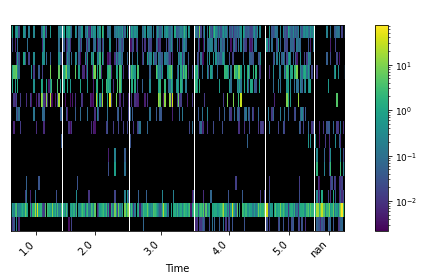

In [19]:
gan.filter_ids(dd_twin.feature_metadata.index).sort_samples('Time').plot(gui='jupyter',sample_field='Time')

In [20]:
# create the colors for the top bar:
gan.sample_metadata['age_rounded'] = gan.sample_metadata['age_months'].astype(int)
gan.sample_metadata['age_rounded_s'] = gan.sample_metadata['age_rounded'].astype(str)
ages = gan.sample_metadata['age_rounded'].unique()
ages.sort()
cdict={}
for cage in ages:
    cinten = 0.2+(cage-ages[0])*0.8/(ages[-1]-ages[0])
    cdict[str(cage)] = (cinten,0,cinten,1)

In [21]:
# taxonomy colors

taxcolors={}
taxcolors['_c__Clostridia']='g'
taxcolors['_c__Bacteroidia']='b'
taxcolors['_c__Gammaproteobacteria']='r'
taxcolors['_c__Bacilli']='y'
taxcolors['_c__Erysipelotrichi']='cyan'
taxcolors['_c__Coriobacteriia']='magenta'
taxcolors['_c__Betaproteobacteria']='black'
taxcolors['Other']='grey'

alltaxcolors={}
for ctax in gan.feature_metadata['class'].unique():
    alltaxcolors[ctax]='grey'
    
alltaxcolors.update(taxcolors)


2021-10-04 10:40:41 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

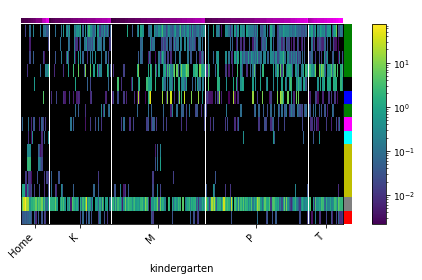

In [22]:
f=gan.filter_ids(dd_twin.feature_metadata.index).sort_samples('age_months').sort_samples('kindergarten').plot(gui='jupyter',sample_field='kindergarten', barx_fields=['age_rounded_s'], barx_label=False, barx_colors=cdict, bary_fields=['class'],bary_colors=alltaxcolors, bary_label=False)

In [23]:
f.figure.savefig('figures/heatmap-daycare-homecare.pdf')

## And save the legend for the taxonomy colors
(we cut it from this figure)

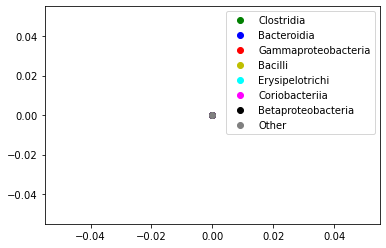

In [24]:
f=plt.figure()
labels=[]
for ck,cv in taxcolors.items():
    plt.plot([0],[0],'o',c=cv)
    labels.append(ck.split('_')[-1])
plt.legend(labels)
f.savefig('figures/daycare-homecare-tax-colors.pdf')

# look at experiments showing the age<1 enrichment

In [25]:
import matplotlib_venn
def plot_venn_group(ganexp, gandir, otherexp, otherdir):
    odir_features=otherexp.feature_metadata[otherexp.feature_metadata._calour_direction == otherdir].index.values
    gandir1 = ganexp.filter_by_metadata('_calour_direction',[gandir],axis='f')
    size1=len(set(gandir1.feature_metadata.index.values).intersection(odir_features))
    print('%s, %s: intersection %d (non-intersect %d)' % (gandir, otherdir, size1, len(gandir1.feature_metadata)-size1))
    gandir2 = ganexp.filter_by_metadata('_calour_direction',[gandir],negate=True,axis='f')
    size2=len(set(gandir2.feature_metadata.index.values).intersection(odir_features))
    print('NOT %s, %s: intersection %d (non-intersect %d)' % (gandir, otherdir, size2, len(gandir2.feature_metadata)-size2))
    f=plt.figure()
#     matplotlib_venn.venn3({'101':size1, '011': size2, '001':len(odir_features),
    print('big circle should be %d' % len(odir_features))
#     matplotlib_venn.venn3({'101':size1, '011': size2, '001':50,
#                            '010': len(gandir2.feature_metadata)-size2,
#                            '100':len(gandir1.feature_metadata)-size1})
#                            set_labels=['Home care', 'Day care'])
    v=matplotlib_venn.venn3({'101':size1, '011': size2, '001':50,
                           '010': len(gandir2.feature_metadata)-size2,
                           '100':len(gandir1.feature_metadata)-size1},
                           set_labels=['', ''])
    aa=v.get_label_by_id('101')
    if aa is not None:
        aa.set_text('')
    v.get_label_by_id('100').set_text('')
    aa=v.get_label_by_id('011')
    if aa is not None:
        aa.set_text('')
    v.get_label_by_id('001').set_text('')
    aa=v.get_label_by_id('010')
    if aa is not None:
        aa.set_text('')
    plt.title('ASVs higher in %s' % otherdir)
    return f

## Changes in the intestinal microbiota following the administration of azithromycin in a randomised placebo-controlled trial among infants in south India
expid: , 339, located in: human-baby-azithromycin

In [41]:
ages=ca.read_amplicon('/Users/amnon/Projects/human-baby-azithromycin/all.biom',
                      '/Users/amnon/Projects/human-baby-azithromycin/map.txt',
                      normalize=100, min_reads=10)

2021-10-04 10:48:24 INFO loaded 280 samples, 996 features
2021-10-04 10:48:24 WARNING Do you forget to normalize your data? It is required before running this function
2021-10-04 10:48:24 INFO After filtering, 280 remain.


In [42]:
ages=ages.filter_samples('non_intervention_antibiotics_days_0_to_14','yes',negate=True)
ages=ages.filter_samples('non_intervention_antibiotics_pre_enrolment','yes',negate=True)
ages=ages.filter_samples('study_day',14,negate=True)
ages.sample_metadata['group']='adult'
ages.sample_metadata.loc[ages.sample_metadata['study_day']==0,'group']='infant'


In [43]:
dd2=ages.diff_abundance('group','adult','infant',random_seed=2020)

2021-10-04 10:48:26 INFO 124 samples with both values
2021-10-04 10:48:26 INFO After filtering, 902 remain.
2021-10-04 10:48:26 INFO 40 samples with value 1 (['adult'])
2021-10-04 10:48:26 INFO number of higher in adult: 406. number of higher in infant : 55. total 461


Home, adult: intersection 1 (non-intersect 7)
NOT Home, adult: intersection 4 (non-intersect 3)
big circle should be 406


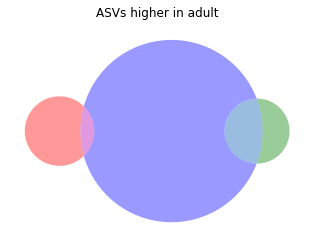

In [44]:
f=plot_venn_group(dd_twin,'Home',dd2,'adult')
f.savefig('figures/venn-india-adult.pdf')

Home, infant: intersection 6 (non-intersect 2)
NOT Home, infant: intersection 0 (non-intersect 7)
big circle should be 55


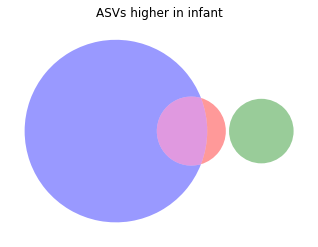

In [45]:
f=plot_venn_group(dd_twin,'Home',dd2,'infant')
f.savefig('figures/venn-india-infant.pdf')

# variation in microbiome lps immunogenicity contributes to autoimmunity in humans
expid: 241, located in: human-three-country

In [63]:
ca.set_log_level('ERROR')
daib=ca.read_amplicon('/Users/amnon/Projects/human-three-country/all.biom',
                      '/Users/amnon/Projects/human-three-country/meta.tsv',
                      normalize=100, min_reads=10)
ca.set_log_level('INFO')

In [64]:
daib=daib.filter_samples('age_at_collection',None)

## single coutries
## Russia

In [65]:
tt=daib.filter_samples('country','RUS')
dd2=tt.correlation('age_at_collection',random_seed=2020)

2021-10-04 10:53:31 INFO After filtering, 3428 remain.
2021-10-04 10:53:33 INFO Positive correlated features : 988. Negative correlated features : 124. total 1112


Home, age_at_collection: intersection 0 (non-intersect 8)
NOT Home, age_at_collection: intersection 4 (non-intersect 3)
big circle should be 988


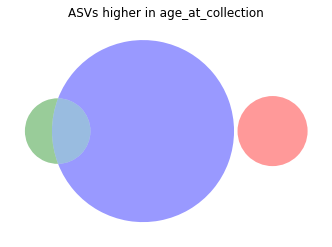

In [66]:
f=plot_venn_group(dd_twin,'Home',dd2,'age_at_collection')
f.savefig('figures/venn-threecountries-russia-old.pdf')

Home, Anti-age_at_collection: intersection 4 (non-intersect 4)
NOT Home, Anti-age_at_collection: intersection 0 (non-intersect 7)
big circle should be 124


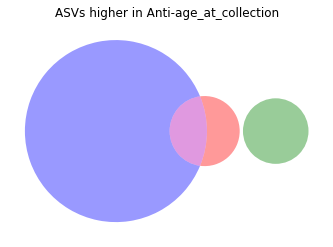

In [67]:
f=plot_venn_group(dd_twin,'Home',dd2,'Anti-age_at_collection')
f.savefig('figures/venn-threecountries-russia-young.pdf')

### Estonia


In [68]:
tt=daib.filter_samples('country','EST')
dd2=tt.correlation('age_at_collection',random_seed=2020)

2021-10-04 10:53:56 INFO After filtering, 4151 remain.
2021-10-04 10:54:00 INFO Positive correlated features : 962. Negative correlated features : 320. total 1282


Home, age_at_collection: intersection 2 (non-intersect 6)
NOT Home, age_at_collection: intersection 5 (non-intersect 2)
big circle should be 962


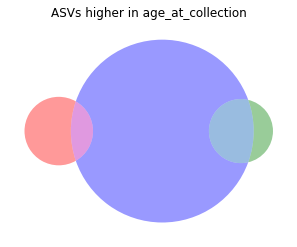

In [69]:
f=plot_venn_group(dd_twin,'Home',dd2,'age_at_collection')
f.savefig('figures/venn-threecountries-estonia-old.pdf')

Home, Anti-age_at_collection: intersection 3 (non-intersect 5)
NOT Home, Anti-age_at_collection: intersection 0 (non-intersect 7)
big circle should be 320


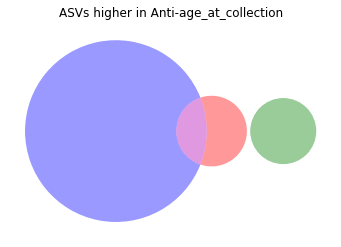

In [70]:
f=plot_venn_group(dd_twin,'Home',dd2,'Anti-age_at_collection')
f.savefig('figures/venn-threecountries-estonia-young.pdf')

### Finland

In [71]:
tt=daib.filter_samples('country','FIN')
dd2=tt.correlation('age_at_collection',random_seed=2020)

2021-10-04 10:55:24 INFO After filtering, 3493 remain.
2021-10-04 10:55:27 INFO Positive correlated features : 774. Negative correlated features : 199. total 973


Home, age_at_collection: intersection 2 (non-intersect 6)
NOT Home, age_at_collection: intersection 4 (non-intersect 3)
big circle should be 774


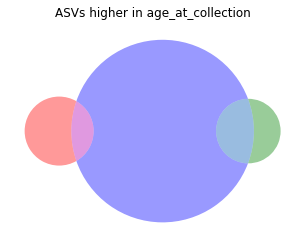

In [73]:
f=plot_venn_group(dd_twin,'Home',dd2,'age_at_collection')
f.savefig('figures/venn-threecountries-finland-old.pdf')

Home, Anti-age_at_collection: intersection 3 (non-intersect 5)
NOT Home, Anti-age_at_collection: intersection 0 (non-intersect 7)
big circle should be 199


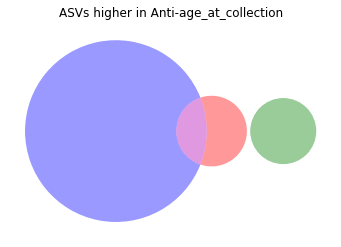

In [74]:
f=plot_venn_group(dd_twin,'Home',dd2,'Anti-age_at_collection')
f.savefig('figures/venn-threecountries-finland-young.pdf')